In [35]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from azure.storage.blob import BlobServiceClient, ContainerClient
from dotenv import load_dotenv
from io import BytesIO
import os
# from mpl_toolkits.mplots3d import Axes3D

load_dotenv("../.env")

In [36]:
service   = BlobServiceClient.from_connection_string(os.getenv("CSTRING"))
container_name = "container1"
blob_name = "processed/data_processed.parquet"

container_client = service.get_container_client(container_name)

In [37]:
blobs_list = container_client.list_blobs()
for blob in blobs_list:
    print(blob.name)

processed/cleaned_data.parquet
processed/data_processed.parquet
raw/data.csv
results/final_data.parquet


In [38]:
blob_client = container_client.get_blob_client(blob_name)
blob_data = blob_client.download_blob().readall()

In [39]:
scaled_features = pd.read_parquet(BytesIO(blob_data))
scaled_features

,recency,frequency,monetary_value
1,6,31,711.79
32,15,17,892.80
49,355,73,1757.55
122,63,17,334.40
139,77,15,296.50
...,...,...,...
100700,96,10,180.60
100710,193,7,80.82
100717,247,7,100.21
100724,36,57,108.45


In [40]:
SSE = []

for cluster in range(1, 10):
    kmeans = KMeans(n_clusters=cluster, init="k-means++")
    kmeans.fit(scaled_features)
    SSE.append(kmeans.inertia_)

# convert results into df
df = pd.DataFrame({
    'Cluster':range(1,10),
    'SSE':SSE
})

Text(0, 0.5, 'Inertia')

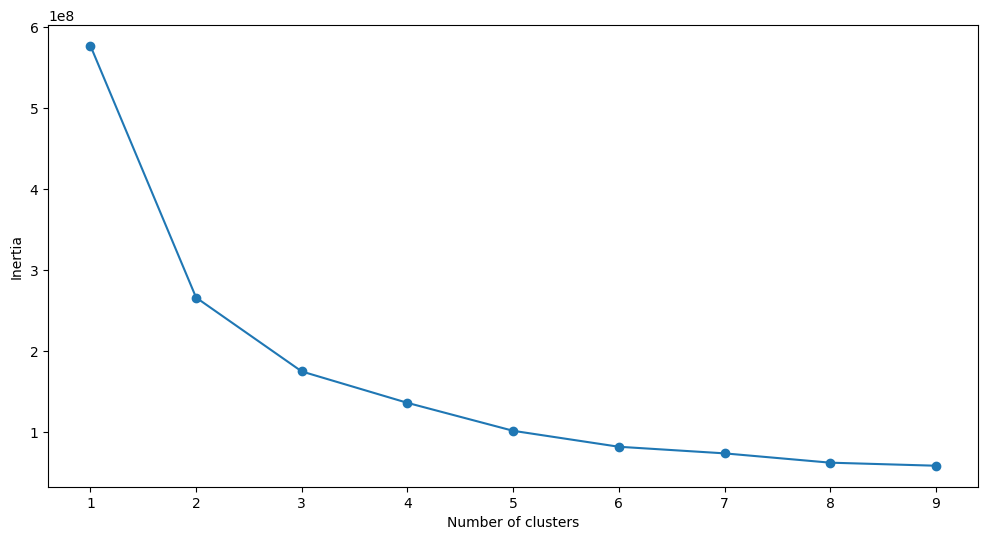

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(df['Cluster'], df['SSE'], marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

Elbow method suggested 3 clusters is optimal.

In [42]:
kmeans = KMeans(n_clusters=3, init="k-means++")
kmeans.fit(scaled_features)

KMeans(n_clusters=3)

### Performance

The higher silhouette score, the better model.

In [43]:
silhouette_score(scaled_features, kmeans.labels_, metric='euclidean')

0.4851889804009213

In [44]:
pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(scaled_features)
frame['cluster'] = pred

In [45]:
frame

,recency,frequency,monetary_value,cluster
1,6,31,711.79,2
32,15,17,892.80,2
49,355,73,1757.55,1
122,63,17,334.40,0
139,77,15,296.50,0
...,...,...,...,...
100700,96,10,180.60,0
100710,193,7,80.82,0
100717,247,7,100.21,0
100724,36,57,108.45,0


Identify distinct traits of customers

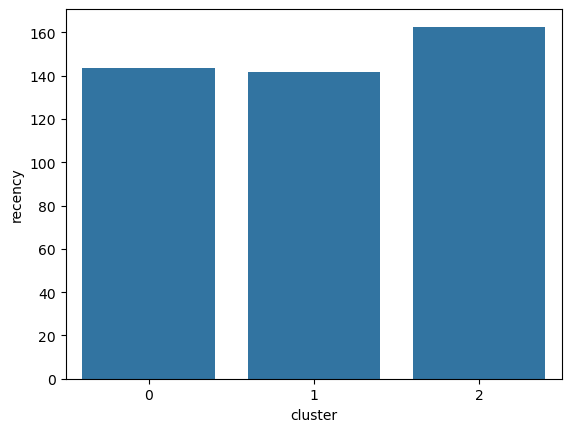

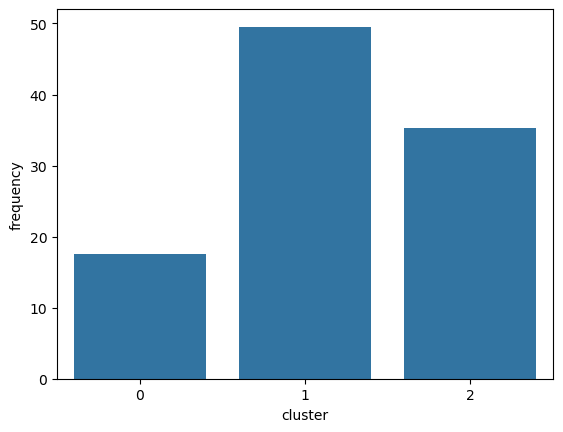

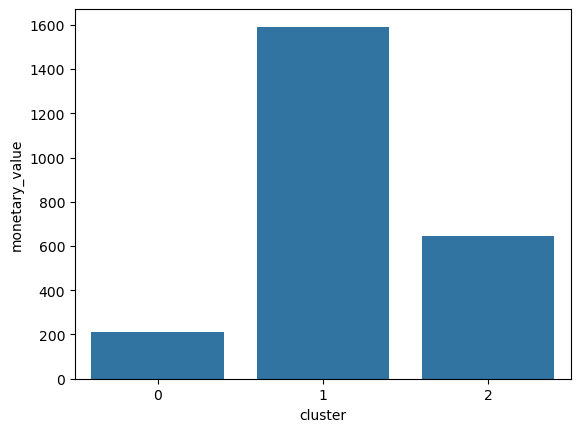

In [46]:
import seaborn as sns
avg_df = frame.groupby(['cluster'], as_index=False).mean()

ls = ['recency', 'frequency', 'monetary_value']
for i in ls:
    sns.barplot(x="cluster", y=str(i), data=avg_df)
    plt.show()

Hierarchical Clustering

In [47]:
percent_missing =round(100*(scaled_features.isnull().sum())/len(scaled_features),2)
percent_missing

recency           0.0
frequency         0.0
monetary_value    0.0
dtype: float64

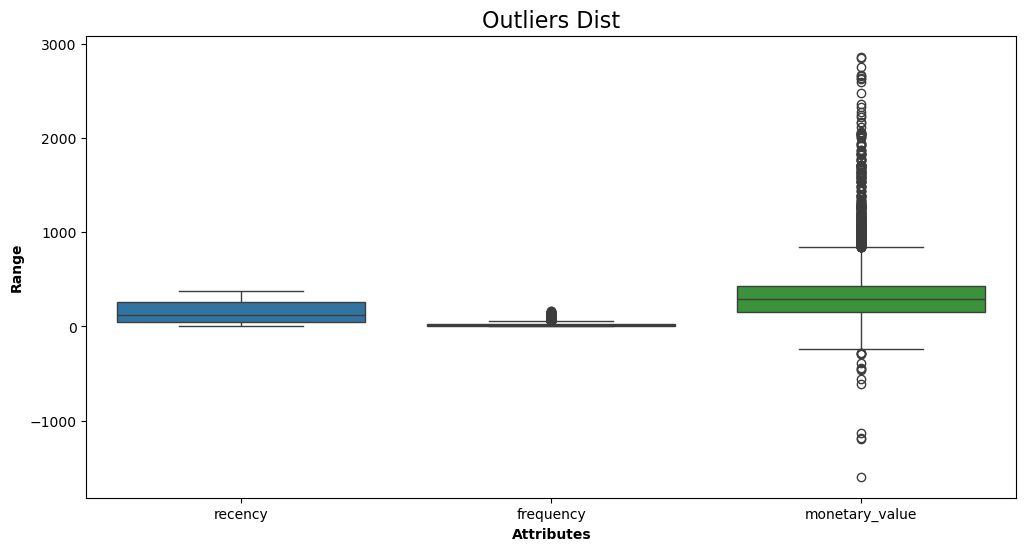

In [48]:
def show_boxplot(df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=scaled_features, orient="v")
    plt.title("Outliers Dist", fontsize=16)
    plt.ylabel("Range", fontweight="bold")
    plt.xlabel("Attributes", fontweight="bold")

show_boxplot(scaled_features)

In [55]:
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
complete_clust = linkage(scaled_features, method="complete", metric="euclidean")
average_clust  = linkage(scaled_features, method="average", metric="euclidean")
single_clust   = linkage(scaled_features, method="single", metric="euclidean")
ward_clust     = linkage(scaled_features, method="ward", metric="euclidean")

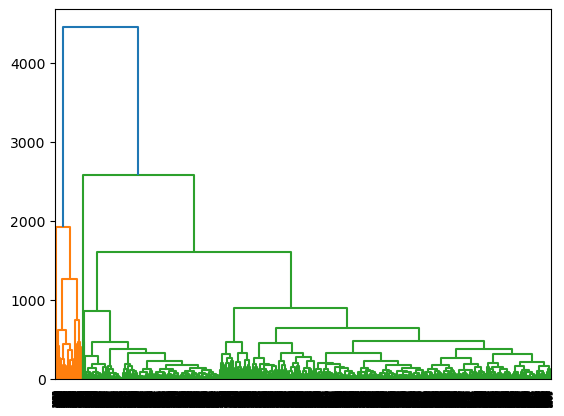

In [50]:
dendrogram(complete_clust)
plt.show()

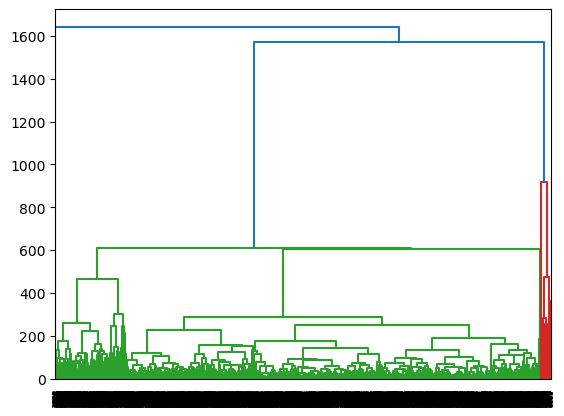

In [51]:
dendrogram(average_clust)
plt.show()

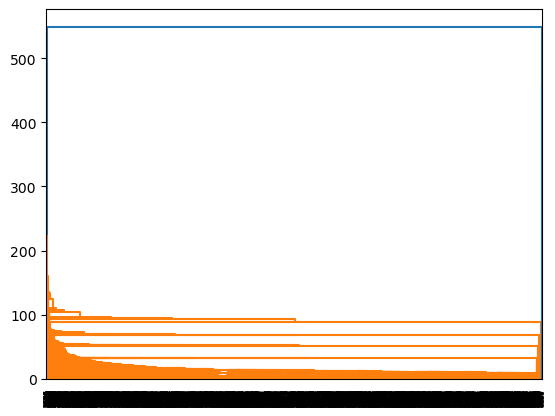

In [52]:
dendrogram(single_clust)
plt.show()

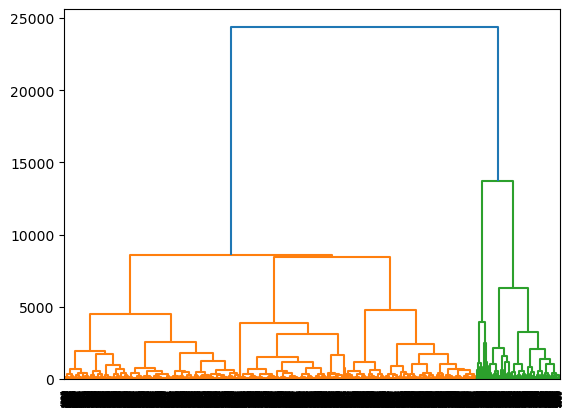

In [56]:
dendrogram(ward_clust)
plt.show()

Ward clustering looks like the best clustering for now. So 2 clusters according to dendrogrmam.

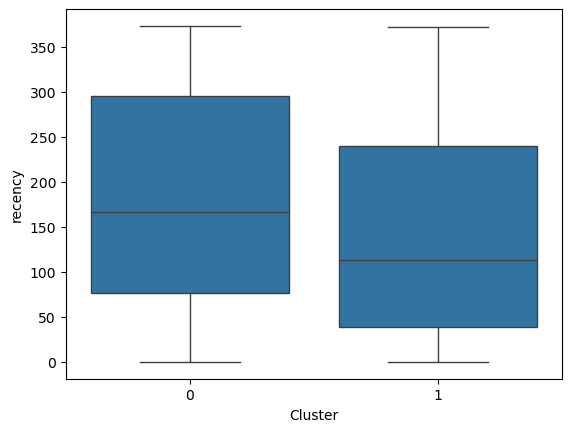

In [59]:
cluster_labels = cut_tree(ward_clust, n_clusters=2).reshape(-1, )
scaled_features["Cluster"] = cluster_labels

sns.boxplot(x='Cluster', y='recency', data=scaled_features)
plt.show()

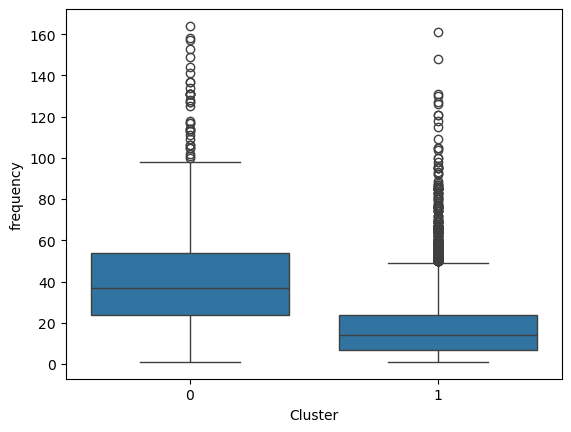

In [60]:
sns.boxplot(x='Cluster', y='frequency', data=scaled_features)
plt.show()

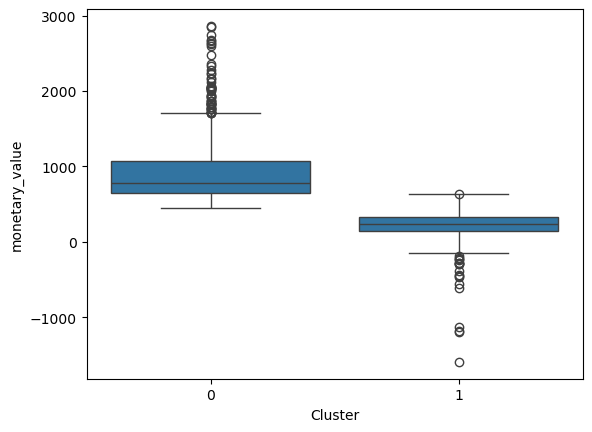

In [61]:
sns.boxplot(x='Cluster', y='monetary_value', data=scaled_features)
plt.show()

In [62]:
scaled_features['Cluster'].value_counts()

Cluster
1    3607
0     731
Name: count, dtype: int64